In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re
import itertools

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

### Load validation predicted probabilities

In [4]:
main_dir = '/tf/notebooks/'

In [5]:
probs_path = main_dir+'final-project/Classification/data/age'

In [6]:
val_pred_probs_mlp_ngram = np.load(os.path.join(probs_path, 'val_pred_probs_mlp_ngram.npy'))
val_pred_probs_cnn = np.load(os.path.join(probs_path, 'val_pred_probs_cnn.npy'))
val_pred_probs_cnn_aggr_chunk = np.load(os.path.join(probs_path, 'val_pred_probs_cnn_aggr_chunk.npy'))

In [7]:
len(val_pred_probs_mlp_ngram), len(val_pred_probs_cnn), len(val_pred_probs_cnn_aggr_chunk)

(76348, 76348, 76348)

In [8]:
with open(os.path.join(probs_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(probs_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)
with open(os.path.join(probs_path, 'val_list'), 'rb') as fp:
    val_list = pickle.load(fp)

In [9]:
len(val_ids), len(val_target), len(val_list)

(76348, 76348, 76348)

In [10]:
val_preds_mlp_ngram = val_pred_probs_mlp_ngram > 0.5
val_preds_cnn = val_pred_probs_cnn > 0.5
val_preds_cnn_aggr_chunk = val_pred_probs_cnn_aggr_chunk > 0.5

In [11]:
sum(val_preds_mlp_ngram), sum(val_preds_cnn), sum(val_preds_cnn_aggr_chunk)

(array([39009]), array([40353]), 40367)

In [12]:
classes = ['Old', 'Young']

In [44]:
np.mean(val_target==val_preds_mlp_ngram.flatten())

0.6480195944883952

Confusion matrix, without normalization
[[24320 13854]
 [13019 25155]]
              precision    recall  f1-score   support

         Old       0.65      0.64      0.64     38174
       Young       0.64      0.66      0.65     38174

   micro avg       0.65      0.65      0.65     76348
   macro avg       0.65      0.65      0.65     76348
weighted avg       0.65      0.65      0.65     76348



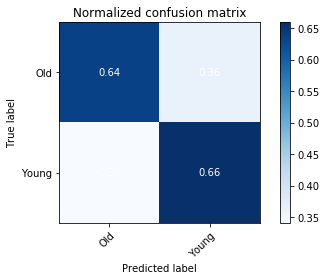

In [13]:
explore_data.plot_confusion_matrix(val_target, val_preds_mlp_ngram, classes, normalize=True)

In [45]:
np.mean(val_target==val_preds_cnn.flatten())

0.6299968564991879

Confusion matrix, without normalization
[[22960 15214]
 [13035 25139]]
              precision    recall  f1-score   support

         Old       0.64      0.60      0.62     38174
       Young       0.62      0.66      0.64     38174

   micro avg       0.63      0.63      0.63     76348
   macro avg       0.63      0.63      0.63     76348
weighted avg       0.63      0.63      0.63     76348



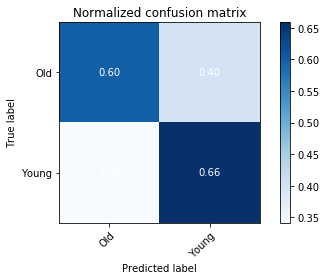

In [14]:
explore_data.plot_confusion_matrix(val_target, val_preds_cnn, classes, normalize=True)

In [46]:
np.mean(val_target==val_preds_cnn_aggr_chunk.flatten())

0.6388248546130875

Confusion matrix, without normalization
[[23290 14884]
 [12691 25483]]
              precision    recall  f1-score   support

         Old       0.65      0.61      0.63     38174
       Young       0.63      0.67      0.65     38174

   micro avg       0.64      0.64      0.64     76348
   macro avg       0.64      0.64      0.64     76348
weighted avg       0.64      0.64      0.64     76348



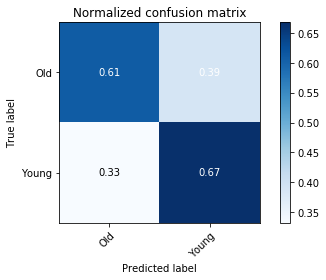

In [15]:
explore_data.plot_confusion_matrix(val_target, val_preds_cnn_aggr_chunk, classes, normalize=True)

In [16]:
len(val_ids)

76348

In [17]:
descr_df = pd.read_csv(main_dir+'final-project/data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(val_ids, dtype=int)]
descr_df.reset_index(inplace=True)
descr_df.drop_duplicates('speech_id', inplace=True)
descr_df.shape

/usr/local/lib/python3.5/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(76348, 17)

In [18]:
pred_df = pd.DataFrame({'ids': np.asarray(val_ids, dtype=np.int64), 
                        'pred_probs_mlp_ngram': val_pred_probs_mlp_ngram.flatten(), 
                        'pred_probs_cnn': val_pred_probs_cnn.flatten(),
                        'pred_probs_cnn_chunk': val_pred_probs_cnn_aggr_chunk.flatten()})
pred_df.shape

(76348, 4)

In [19]:
pred_df.head()

,ids,pred_probs_cnn,pred_probs_cnn_chunk,pred_probs_mlp_ngram
0,1060162543,0.588013,0.608967,0.758535
1,980236360,0.854308,0.576761,0.768939
2,990257551,0.173026,0.421584,0.422959
3,1010233637,0.765873,0.544882,0.384004
4,980084907,0.221452,0.435048,0.265079


In [20]:
descr_pred_df = descr_df.merge(pred_df, left_on='speech_id', right_on='ids')
descr_pred_df.shape

(76348, 21)

In [21]:
preds = [
    'pred_probs_mlp_ngram',
    'pred_probs_cnn', 
    'pred_probs_cnn_chunk'
]

In [22]:
descr_pred_df[preds+['Age_lt_med']].groupby('Age_lt_med').mean()

,pred_probs_mlp_ngram,pred_probs_cnn,pred_probs_cnn_chunk
Age_lt_med,,,
0.0,0.424094,0.447589,0.470995
1.0,0.576096,0.568008,0.527011


In [23]:
preds_combo = []
for i in range(1, len(preds)+1):
    preds_combo.extend(list(itertools.combinations(preds, i)))
len(preds_combo)

7

In [24]:
preds_combo_results = []
for i in range(len(preds_combo)):
    temp = descr_pred_df[list(preds_combo[i])]
    avg = temp.mean(axis=1)
    avg_pred = avg > 0.5
    result = np.mean(avg_pred==descr_pred_df['Age_lt_med'])
    preds_combo_results.append((preds_combo[i], result))

In [25]:
preds_combo_results = sorted(preds_combo_results, key=lambda x: -x[1])
preds_combo_results

[(('pred_probs_mlp_ngram', 'pred_probs_cnn_chunk'), 0.654070833551632),
 (('pred_probs_mlp_ngram', 'pred_probs_cnn', 'pred_probs_cnn_chunk'),
  0.6532718604285639),
 (('pred_probs_mlp_ngram', 'pred_probs_cnn'), 0.6515560329019752),
 (('pred_probs_mlp_ngram',), 0.6469586629643213),
 (('pred_probs_cnn_chunk',), 0.6376591397286111),
 (('pred_probs_cnn', 'pred_probs_cnn_chunk'), 0.6375805522083093),
 (('pred_probs_cnn',), 0.6284382040132027)]

In [26]:
descr_pred_df['pred_probs_combo'] = descr_pred_df[list(preds_combo_results[0][0])].mean(axis=1)
descr_pred_df['pred_combo'] = descr_pred_df['pred_probs_combo'] > 0.5
np.mean(val_target==descr_pred_df['pred_combo'].values.flatten())

0.6552365484361083

### Save the main dataframe

In [27]:
keep_cols = ['speech_id',
 'date',
 'char_count',
 'word_count',
 'speakerid',
 'Party',
 'Congress',
 'Chamber',
 'State',
 'Ethnicity',
 'Age',
 'Age_lt_med',
 'NonWhite',
 'Female',
 'speaker',
 'Full Name',
 'match',
 'ids',
 'pred_probs_combo',
 'pred_combo']

In [28]:
descr_pred_df[keep_cols].to_pickle(os.path.join(probs_path, 'age_preds.pkl'))

### Evaluating final predictions

Confusion matrix, without normalization
[[24261 13913]
 [12409 25765]]
              precision    recall  f1-score   support

         Old       0.66      0.64      0.65     38174
       Young       0.65      0.67      0.66     38174

   micro avg       0.66      0.66      0.66     76348
   macro avg       0.66      0.66      0.66     76348
weighted avg       0.66      0.66      0.66     76348



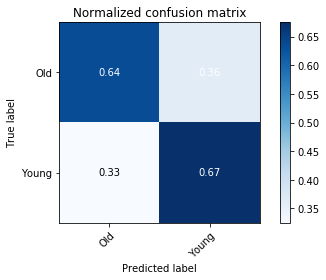

In [29]:
explore_data.plot_confusion_matrix(val_target, descr_pred_df['pred_combo'], classes, normalize=True)

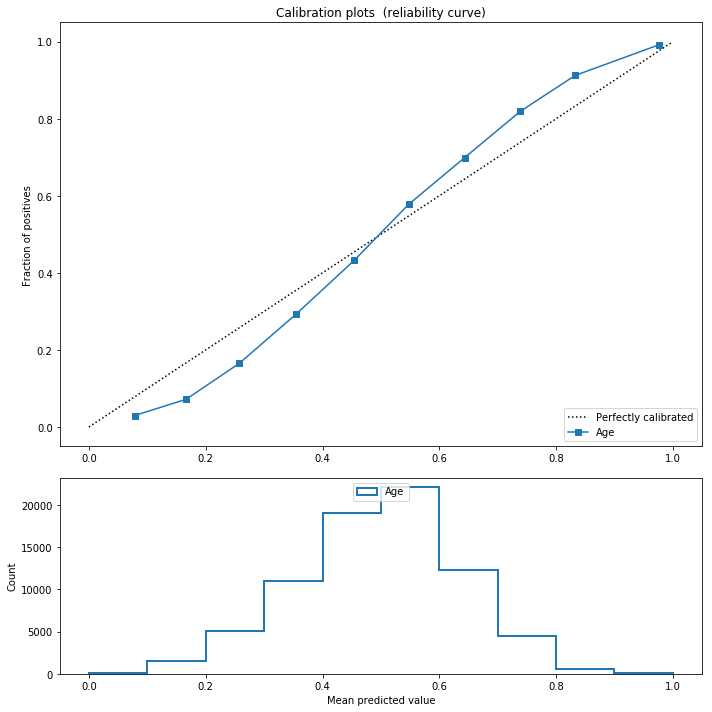

In [30]:
explore_data.plot_calibration_curve(val_target, descr_pred_df['pred_probs_combo'], 'Age')

In [31]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(descr_pred_df['pred_probs_combo'], 
                                   val_ids, 
                                   descr_df.set_index('speech_id'))

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge  Party_D  Chamber_H  AvgWordCount
base  0.095641       0.095824  55.899225  0.52651   0.617646     381.12312


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.55,0.62,1.10,1.01,0.28,0.98
0.6,1.12,1.13,1.00,1.05,1.11,1.03
1.0,1.17,1.08,0.91,0.88,1.47,0.96


In [32]:
reload(explore_data)
explore_data.compare_ngrams(val_list, descr_pred_df['pred_probs_combo'], 
                            ngram_range=(1, 1),
                            top_k=20)


Top 20 ngrams by differentiating score:


,ngram,<0.4,<0.6,<1.0,score
0,unanimous,4543.0,3338.0,365.0,2473.0
1,senators,4981.0,3065.0,365.0,1107.0
2,distinguished,3999.0,4167.0,1059.0,696.0
3,proceed,1539.0,868.0,149.0,625.0
4,yielding,363.0,2298.0,1905.0,587.0
5,leader,3976.0,3768.0,1300.0,507.0
6,session,1750.0,1311.0,392.0,452.0
7,printed,1474.0,1864.0,214.0,396.0
8,amendments,4292.0,4263.0,1021.0,395.0
9,minutes,2307.0,2433.0,746.0,344.0


## Congressperson level analysis

In [33]:
speaker_df = descr_pred_df[['Full Name', 'Party', 'State', 'Female', 'NonWhite', 'Age', 'Age_lt_med', 'pred_probs_combo']]\
                .groupby(['Full Name', 'Party', 'State', 'Female', 'NonWhite', 'Age_lt_med'])\
                .agg({'pred_probs_combo':['mean', 'count'], 'Age': ['mean']})\
                .reset_index()
speaker_df.columns = ['_'.join(col) for col in speaker_df.columns]
speaker_df['Age_lt_med_pred_'] = speaker_df.pred_probs_combo_mean > 0.5
speaker_df.shape

(2218, 10)

Confusion matrix, without normalization
[[ 366  637]
 [ 166 1049]]
              precision    recall  f1-score   support

         Old       0.69      0.36      0.48      1003
       Young       0.62      0.86      0.72      1215

   micro avg       0.64      0.64      0.64      2218
   macro avg       0.66      0.61      0.60      2218
weighted avg       0.65      0.64      0.61      2218



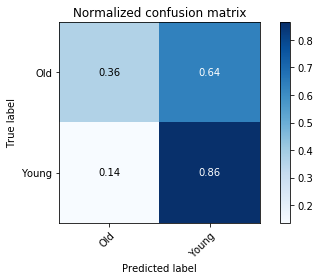

In [34]:
explore_data.plot_confusion_matrix(speaker_df.Age_lt_med_, speaker_df.Age_lt_med_pred_, classes, normalize=True)

In [35]:
speaker_df.pred_probs_combo_count.median()

17.0

In [36]:
speaker_med_df = speaker_df[speaker_df.pred_probs_combo_count > speaker_df.pred_probs_combo_count.median()]
speaker_med_df.shape

(1086, 10)

Confusion matrix, without normalization
[[242 263]
 [ 93 488]]
              precision    recall  f1-score   support

         Old       0.72      0.48      0.58       505
       Young       0.65      0.84      0.73       581

   micro avg       0.67      0.67      0.67      1086
   macro avg       0.69      0.66      0.65      1086
weighted avg       0.68      0.67      0.66      1086



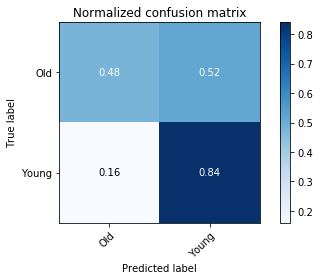

In [37]:
explore_data.plot_confusion_matrix(speaker_med_df.Age_lt_med_, speaker_med_df.Age_lt_med_pred_, classes, normalize=True)

In [38]:
tp = np.argmax(speaker_med_df[speaker_med_df.Age_lt_med_==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Age_lt_med_==1].iloc[tp]

Full Name_                GRAVES, SAM
Party_                              R
State_                             MO
Female_                             0
NonWhite_                           0
Age_lt_med_                         1
pred_probs_combo_mean        0.882791
pred_probs_combo_count             81
Age_mean                       45.321
Age_lt_med_pred_                 True
Name: 841, dtype: object

In [39]:
tn = np.argmin(speaker_med_df[speaker_med_df.Age_lt_med_==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Age_lt_med_==0].iloc[tn]

Full Name_                BAKER, HOWARD
Party_                                R
State_                               TN
Female_                               0
NonWhite_                             0
Age_lt_med_                           0
pred_probs_combo_mean          0.233889
pred_probs_combo_count              521
Age_mean                        57.9981
Age_lt_med_pred_                  False
Name: 68, dtype: object

In [40]:
fp = np.argmax(speaker_med_df[speaker_med_df.Age_lt_med_==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Age_lt_med_==0].iloc[fp]

Full Name_                COSTA, JIM
Party_                             D
State_                            CA
Female_                            0
NonWhite_                          0
Age_lt_med_                        0
pred_probs_combo_mean       0.630842
pred_probs_combo_count            25
Age_mean                       61.44
Age_lt_med_pred_                True
Name: 443, dtype: object

In [41]:
fn = np.argmin(speaker_med_df[speaker_med_df.Age_lt_med_==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Age_lt_med_==1].iloc[fn]

Full Name_                SESSIONS, JEFFERSON
Party_                                      R
State_                                     AL
Female_                                     0
NonWhite_                                   0
Age_lt_med_                                 1
pred_probs_combo_mean                0.362597
pred_probs_combo_count                     45
Age_mean                              53.0667
Age_lt_med_pred_                        False
Name: 1868, dtype: object

## Congress level analysis

In [42]:
congress_df = descr_pred_df[['Congress', 'Age_lt_med', 'Age', 'pred_probs_combo', 'pred_combo']]\
                .groupby('Congress')\
                .agg({'Age_lt_med': ['mean', 'sum'], 'pred_combo': ['mean'], 'Age': ['mean']})\
                .reset_index()
congress_df.columns = ['_'.join(col) for col in congress_df.columns]
congress_df['Prediction_balance'] = congress_df.pred_combo_mean / congress_df.Age_lt_med_mean
congress_df.shape

(18, 6)

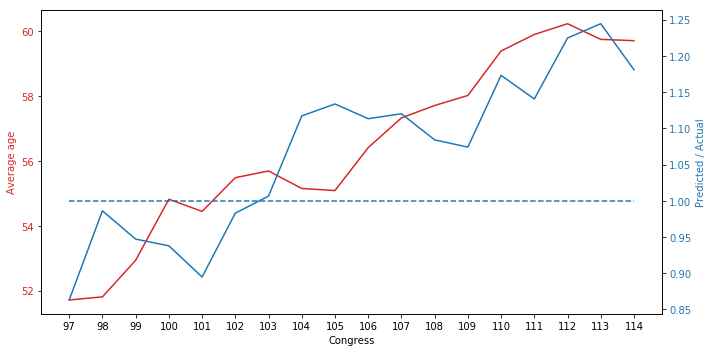

In [43]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Congress')
ax1.set_ylabel('Average age', color=color)
ax1.plot(congress_df.Congress_, congress_df.Age_mean, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Predicted / Actual', color=color)  # we already handled the x-label with ax1
ax2.plot(congress_df.Congress_, congress_df.Prediction_balance, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.hlines(y=1,xmin=97,xmax=114, color=color, linestyles='dashed')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(range(97,115))
plt.show()